# Bivariate Significance Tests and Correlation
For this lab, we will be using the transportation.dta dataset created in [our previous lab](https://nbviewer.jupyter.org/github/bowendc/labs/blob/master/lab_datamanagement2.ipynb). 

Let's set up our code and open the dataset:

In [1]:
* if needed, set your working directory to the location of transportation.dta
use transportation.dta, clear
describe




Contains data from transportation.dta
  obs:         3,220                          
 vars:            12                          3 Nov 2020 10:36
 size:       186,760                          
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
geo_id          str14   %14s                  GEO_ID
medianfamilyinc long    %10.0g                S1903_C03_015E
totalworkers    long    %10.0g                S0802_C01_001E
drovealone      long    %10.0g                S0802_C02_001E
mediantravel    double  %10.0g                S0802_C01_090E
mg_county       byte    %23.0g     _merge     
fips            byte    %10.0g                
state           str14   %14s                  
stateid         byte    %8.0g                 
stateabv        str2    %9s                   
gastax

First, let's create a new variable that equals the proportion of workers in the county who drive to work alone.

In [2]:
gen prop_drovealone = drovealone / totalworkers

(1 missing value generated)


## Difference of means and proportions

### ttest

The ***ttest*** command conducts difference of means test significance tests. In order to compare the means, we need to recode our independent varible into only two groups. Let's recode the interval variable _totalworkers_ as a measure of the population size of a county into a four-point ordinal measure.

After the recode, we can run the ***ttest*** command to see if the mean of _prop_drovealone_ in the smallest counties differs significantly from the mean in the largest counties.

*difference of means test: 
recode totalworkers (0/50000=0 "Small")(50000/150000=1 "Med") ///
    (150000/500000=2 "Large") ///
    (500000/10000000=3 "Very Large"), gen(size)

ttest prop_drovealone if size==0 | size==3, by(size) unequal

This table is a little confusing! Let's focus on what matters. In the "Mean" column, you can see the $\bar{y_1}$ and $\bar{y_2}$. The "diff" row shows $\bar{y_1} - \bar{y_2}$, the standard error of the difference, and the 95% confidence interal around the difference. The two-tailed p-value is available underneath "Ha: diff!= 0".

### prtest

Difference of sample proportions significance tests can be conducted using the command ***prtest***. The syntax follows ***ttest***. In order to run the command, you need to have a dummy variable for your dependent variable. Notice the use of Z scores instead of t scores below. 

In [4]:
*difference of proportions test:
recode mediantravel (0 /20=1 "Short")(20/100=0 "Long"), gen(shortcommute)

prtest shortcommute if size==0 | size==1, by(size)


(1483 differences between mediantravel and shortcommute)


Two-sample test of proportions                 Small: Number of obs =     1154
                                                 Med: Number of obs =      149
------------------------------------------------------------------------------
       Group |       Mean   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       Small |   .3214905   .0137486                      .2945437    .3484373
         Med |   .1610738   .0301149                      .1020497    .2200979
-------------+----------------------------------------------------------------
        diff |   .1604166   .0331048                      .0955323     .225301
             |  under Ho:   .0400104     4.01   0.000
------------------------------------------------------------------------------
        diff = prop(Small) - prop(Med)                            z =   4.0094
    Ho: diff = 0


## $\chi^2$ test

$\chi^2$ tests can be conducted very easily using the crosstab syntax. Just add the _chi2_ option at the end of your command. Stata will print the value of $\chi^2$, the degrees of freedom of the test, and the p-value below the crosstab.

In [5]:
tab shortcommute size, col chi2


+-------------------+
| Key               |
|-------------------|
|     frequency     |
| column percentage |
+-------------------+

 RECODE of |
mediantrav |
        el |
(S0802_C01 |   RECODE of totalworkers (S0802_C01_001E)
    _090E) |     Small        Med      Large  Very Larg |     Total
-----------+--------------------------------------------+----------
      Long |       783        125        132         44 |     1,084 
           |     67.85      83.89      97.06     100.00 |     73.10 
-----------+--------------------------------------------+----------
     Short |       371         24          4          0 |       399 
           |     32.15      16.11       2.94       0.00 |     26.90 
-----------+--------------------------------------------+----------
     Total |     1,154        149        136         44 |     1,483 
           |    100.00     100.00     100.00     100.00 |    100.00 

          Pearson chi2(3) =  80.8787   Pr = 0.000


## Pearson's _r_ 

As you know, Persons's _r_ correlation coefficient is appropriate for continuous/interval data. Let's take a quick look at a scatterplot first, then we can play around with running correlations on these variables.

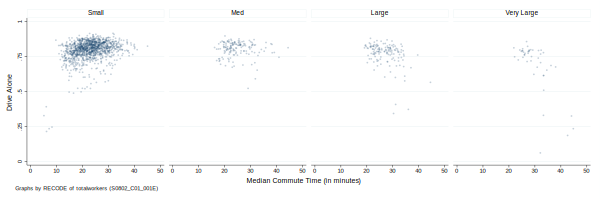

In [28]:
scatter prop_drovealone mediantravel, by(size, rows(1) graphregion(color(white)) ///
    plotregion(color(white)) ) subtitle(, bcolor(white) lwidth(none)) ///
    mcolor(navy%25) msize(small) mlwidth(none) ///
     ysize(2) xsize(6) xtitle("Median Commute Time (in minutes)") ///
    xlabel(0(10)50) ylabel(0(.25)1) ///
    ytitle(Drive Alone)

To run a correlation, I recommend using Stata's ***pwcorr*** command. The syntax is very simple: just list the variables you want included in a correlation matrix after ***pwcorr***. You can request a p-value by including the _sig_ option or you can star all correlations that are significant at specific significance levels by using the _star()_ option. 

In [7]:
pwcorr mediantravel prop_drovealone
pwcorr mediantravel prop_drovealone, sig
pwcorr mediantravel prop_drovealone, star(.05)



             | median~l prop_d~e
-------------+------------------
mediantravel |   1.0000 
prop_drove~e |   0.0581   1.0000 


             | median~l prop_d~e
-------------+------------------
mediantravel |   1.0000 
             |
             |
prop_drove~e |   0.0581   1.0000 
             |   0.0253
             |


             | median~l prop_d~e
-------------+------------------
mediantravel |   1.0000 
prop_drove~e |   0.0581*  1.0000 


To control for a third variable, use the ***bysort*** prefix. ***bysort*** can be specified in front of many Stata commands to run the command by categories of the variable(s) listed. In the case of the example below, we can calculate the correlation between _prop_drovealone_ and _mediantravel_ inside of each _size_ category: 

In [8]:
bysort size: pwcorr prop_drovealone mediantravel, star(.05)


--------------------------------------------------------------------------------
-> size = Small

             | prop_d~e median~l
-------------+------------------
prop_drove~e |   1.0000 
mediantravel |   0.2891*  1.0000 

--------------------------------------------------------------------------------
-> size = Med

             | prop_d~e median~l
-------------+------------------
prop_drove~e |   1.0000 
mediantravel |  -0.0344   1.0000 

--------------------------------------------------------------------------------
-> size = Large

             | prop_d~e median~l
-------------+------------------
prop_drove~e |   1.0000 
mediantravel |  -0.3848*  1.0000 

--------------------------------------------------------------------------------
-> size = Very Large

             | prop_d~e median~l
-------------+------------------
prop_drove~e |   1.0000 
mediantravel |  -0.7063*  1.0000 

--------------------------------------------------------------------------------
-> size = .
no obse

Finally, it is nice to look at multiple bivariate correlations in the same correlation matrix. The matrix below does not control for _gastax_; instead, it shows the bivariate correlation between _mediantravel_ and _gastax_ (.1809) and between _gastax_ and _prop_drovealone_ (-.0033). 

In [9]:
pwcorr mediantravel prop_drovealone gastax, star(.05)


             | median~l prop_d~e   gastax
-------------+---------------------------
mediantravel |   1.0000 
prop_drove~e |   0.0581*  1.0000 
      gastax |   0.1809* -0.0033   1.0000 
